# **Tutorial 3 Scalability on Million-Cell Tissue Sections**

In [29]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import SpatialEx as se

device = 'cuda:3'

## 1. Prepare the dataset

### Arange your dataset as following
```
datasets/
│
├── Human_Breast_IDC_Big1/                        # The 1st slice
│   ├── cell_feature_matrix.h5                    
│   ├── cells.csv
│   ├── Xenium_V1_FFPE_Human_Breast_IDC_Big_1_he_unaligned_image.ome.tif          
│   └── Xenium_V1_FFPE_Human_Breast_IDC_Big_1_he_unaligned_image_matrix.csv
│
├── Human_Breast_IDC_Big2/                        # The 2nd slice
│   ├── cell_feature_matrix.h5
│   ├── cells.csv
│   ├── Xenium_V1_FFPE_Human_Breast_IDC_Big_2_he_unaligned_image.ome.tif       
│   └── Xenium_V1_FFPE_Human_Breast_IDC_Big_2_he_unaligned_image_matrix.csv
│
├── Big_by_name.csv                               # Simulate panel integration
```

In [ ]:
resolution = 64
save_root = '/home/wcy/code/datasets/Xenium/'
sample_name1 = 'Human_Breast_IDC_Big1'
sample_name2 = 'Human_Breast_IDC_Big2'
panel_selection = pd.read_csv('/home/wcy/code/pyFile/Xenium_modality_impute/inputs/panel/Big_by_name.csv', index_col=0)
panelA = panel_selection.index[panel_selection['panelA']==1]
panelB = panel_selection.index[panel_selection['panelB']==1]

In [ ]:
file_path1 = save_root + sample_name1 + '/cell_feature_matrix.h5'
obs_path1 = save_root + sample_name1 + '/cells.csv'
img_path1 = save_root + sample_name1 + '/Xenium_V1_FFPE_Human_Breast_IDC_Big_1_he_unaligned_image.ome.tif'
transform_mtx_path1 = save_root + sample_name1 + '/Xenium_V1_FFPE_Human_Breast_IDC_Big_1_he_unaligned_image_matrix.csv'

adata1 = se.pp.Read_Xenium(file_path1, obs_path1)
adata1 = se.pp.Preprocess_adata(adata1, selected_genes=panelA)                                              

img, scale = se.pp.Read_HE_image(img_path1)
transform_mtx = pd.read_csv(transform_mtx_path1, header=None).values
adata1 = se.pp.Register_physical_to_pixel(adata1, transform_mtx, scale=scale)
he_patches, adata1 = se.pp.Tiling_HE_patches(resolution, adata1, img)
adata1 = se.pp.Extract_HE_patches_representaion(he_patches, store_key='he', adata=adata1, image_encoder='uni', device=device)

In [2]:
file_path2 = save_root + sample_name2 + '/cell_feature_matrix.h5'
obs_path2 = save_root + sample_name2 + '/cells.csv'
img_path2 = save_root + sample_name2 + '/Xenium_V1_FFPE_Human_Breast_IDC_Big_2_he_unaligned_image.ome.tif'
transform_mtx_path2 = save_root + sample_name2 + '/Xenium_V1_FFPE_Human_Breast_IDC_Big_2_he_imagealignment.csv'

adata2 = se.pp.Read_Xenium(file_path2, obs_path2)    
adata2 = se.pp.Preprocess_adata(adata2, selected_genes=panelB)

img, scale = se.pp.Read_HE_image(img_path2)
transform_mtx = pd.read_csv(transform_mtx_path2, header=None).values
adata2 = se.pp.Register_physical_to_pixel(adata2, transform_mtx, scale=scale)
he_patches, adata2 = se.pp.Tiling_HE_patches(resolution, adata2, img)
adata2 = se.pp.Extract_HE_patches_representaion(he_patches, store_key='he', adata=adata2, image_encoder='uni', device=device)

## 2. Train SpatialEx+

In [3]:
num_neighbors = 7
epochs = 200

graph1 = se.pp.Build_hypergraph_spatial_and_HE(adata1, num_neighbors, graph_kind='spatial', return_type='crs')
graph2 = se.pp.Build_hypergraph_spatial_and_HE(adata2, num_neighbors, graph_kind='spatial', return_type='crs')

spatialexp = se.SpatialExP_Big(adata1, adata2, graph1, graph2, epochs=epochs, device=device)
spatialexp.train()
panelB1, panelA2 = spatialexp.auto_inference()

836616  cells are included in its nearest spot!
834928  cells are included in its nearest spot!


## 3. Evaluation

### 3.1 Quantatitive metrics

#### 3.1.1 Compute metrics for predicted panelB on Slice 1

In [8]:
file_path1 = save_root + sample_name1 + '/cell_feature_matrix.h5'
obs_path1 = save_root + sample_name1 + '/cells.csv'
adata1_gt = se.pp.Read_Xenium(file_path1, obs_path1)[adata1.obs_names]
adata1_gt = se.pp.Preprocess_adata(adata1_gt, cell_mRNA_cutoff=0, selected_genes=panelB)

graph = se.pp.Build_graph(adata1_gt.obsm['spatial'], graph_type='knn', weighted='gaussian', apply_normalize='row', return_type='crs')
ssim, ssim_reduce = se.utils.Compute_metrics(adata1_gt.X.copy(), panelB1.copy(), metric='ssim', graph=graph, reduce='mean')
pcc, pcc_reduce = se.utils.Compute_metrics(adata1_gt.X.copy(), panelB1.copy(), metric='pcc', reduce='mean')
cmd, cmd_reduce = se.utils.Compute_metrics(adata1_gt.X.copy(), panelB1.copy(), metric='cmd', reduce='mean')
print('Evaluation of the predicted Panel B on Slice 1, PCC: ', pcc_reduce, ' SSIM: ', ssim_reduce, ' CMD: ', cmd_reduce)     

x shape is  836616
cell number is greater than 200000
To avoid memory overflow, the data is splited into 167324 cells batches.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:25<00:00, 53.14s/it]


Evaluation of the predicted Panel B on Slice 1, PCC:  0.1075825  SSIM:  0.3736042618564828  CMD:  0.31290859779254976


#### 3.1.2 Compute metrics for predicted panelA on Slice 2

In [9]:
file_path2 = save_root + sample_name2 + '/cell_feature_matrix.h5'
obs_path2 = save_root + sample_name2 + '/cells.csv'
adata2_gt = se.pp.Read_Xenium(file_path2, obs_path2)[adata2.obs_names]
adata2_gt = se.pp.Preprocess_adata(adata2_gt, cell_mRNA_cutoff=0, selected_genes=panelA)

graph = se.pp.Build_graph(adata2_gt.obsm['spatial'], graph_type='knn', weighted='gaussian', apply_normalize='row', return_type='crs')
ssim, ssim_reduce = se.utils.Compute_metrics(adata2_gt.X.copy(), panelA2.copy(), metric='ssim', graph=graph, reduce='mean')
pcc, pcc_reduce = se.utils.Compute_metrics(adata2_gt.X.copy(), panelA2.copy(), metric='pcc', reduce='mean')
cmd, cmd_reduce = se.utils.Compute_metrics(adata2_gt.X.copy(), panelA2.copy(), metric='cmd', reduce='mean')
print('Evaluation of the predicted Panel A on Slice 2, PCC: ', pcc_reduce, ' SSIM: ', ssim_reduce, ' CMD: ', cmd_reduce)     

x shape is  834928
cell number is greater than 200000
To avoid memory overflow, the data is splited into 166986 cells batches.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:14<00:00, 38.88s/it]


Evaluation of the predicted Panel A on Slice 2, PCC:  0.19868572  SSIM:  0.4026186720606638  CMD:  0.31016948910561426


### 3.2 Visualization

#### 3.2.1 Predicted Panel B on Slice 1

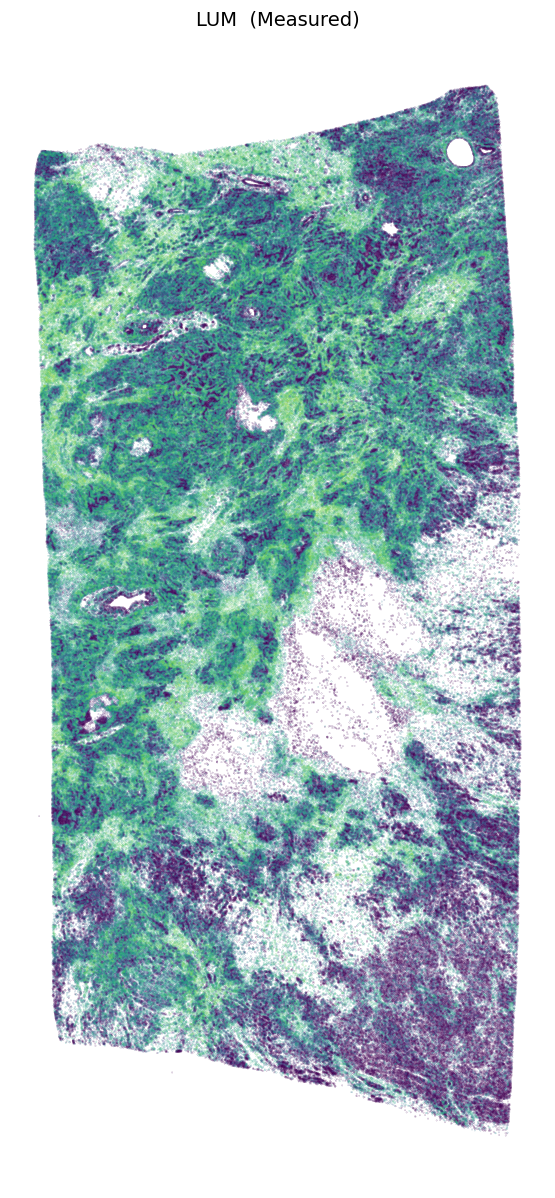

In [21]:
gene_name = 'LUM'
gene_idx = np.where(adata2.var_names == gene_name)[0]

plt.figure(figsize=(10, 15))
spatial = adata1.obsm['spatial']
value = adata1_gt[:, gene_name].X.squeeze()
order = np.argsort(value)
plt.scatter(spatial[order, 0], spatial[order, 1], c=value[order], s=0.01)
plt.gca().set_aspect(1)
plt.axis('off')
plt.title(gene_name + '  (Measured)', fontsize=14)
plt.show()

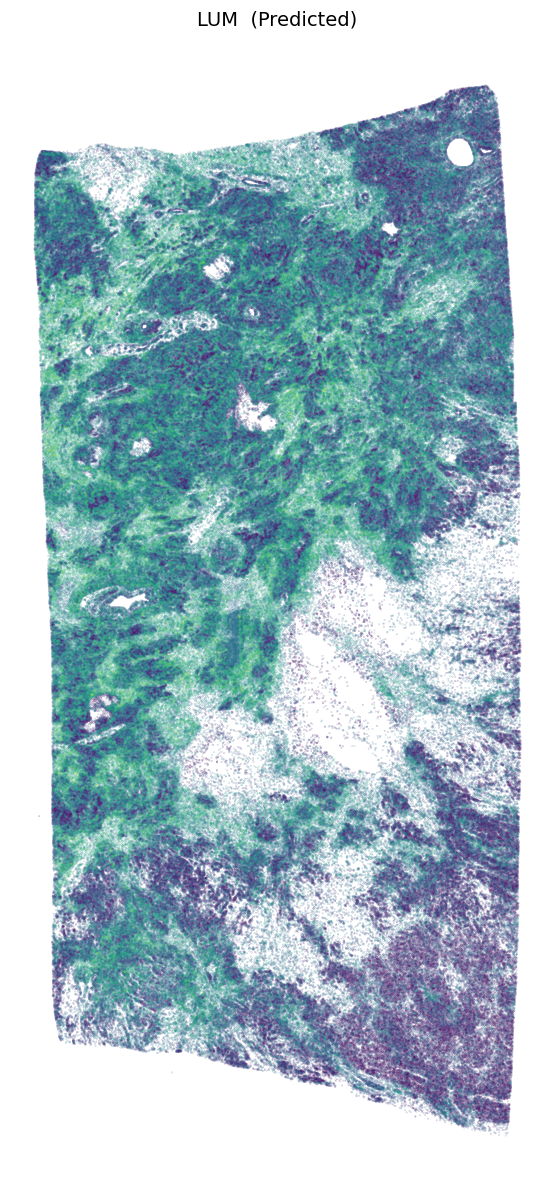

In [28]:
gene_name = 'LUM'
gene_idx = np.where(adata2.var_names == gene_name)[0]

plt.figure(figsize=(10, 15))
spatial = adata1.obsm['spatial']
value = panelB1[:, gene_idx].squeeze()
order = np.argsort(value)
plt.scatter(spatial[order, 0], spatial[order, 1], c=value[order], vmin=0.2, vmax=value.max()-1, s=0.01)
plt.gca().set_aspect(1)
plt.axis('off')
plt.title(gene_name + '  (Predicted)', fontsize=14)
plt.show()

#### 3.2.1 Predicted Panel A on Slice 2

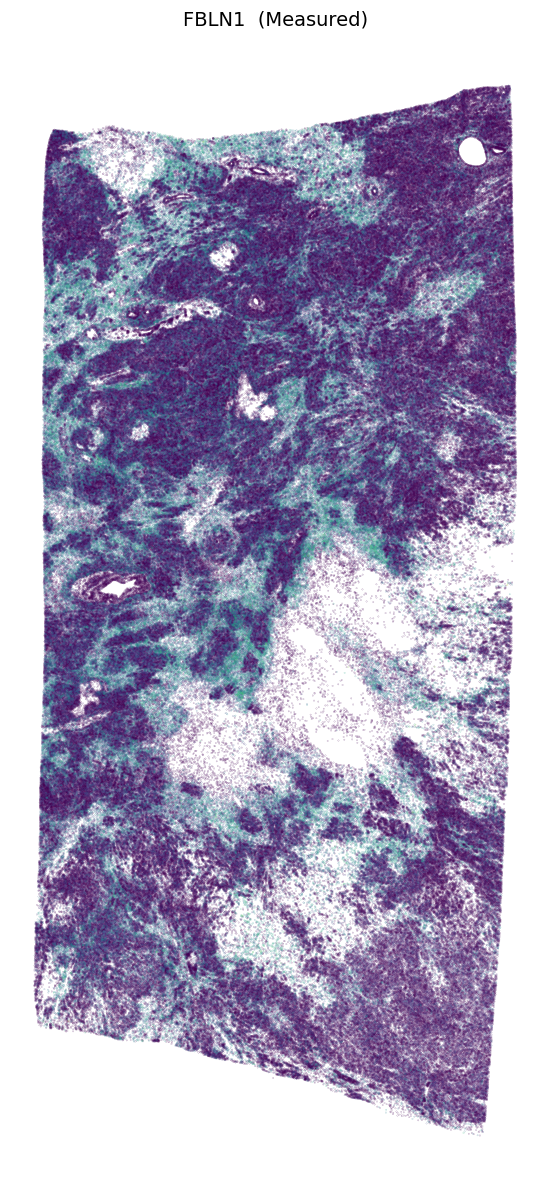

In [20]:
gene_name = 'FBLN1'
gene_idx = np.where(adata1.var_names == gene_name)[0]

plt.figure(figsize=(10, 15))
spatial = adata2.obsm['spatial']
value = adata2_gt[:, gene_name].X.squeeze()
order = np.argsort(value)
plt.scatter(spatial[order, 0], spatial[order, 1], c=value[order], s=0.01)
plt.gca().set_aspect(1)
plt.axis('off')
plt.title(gene_name + '  (Measured)', fontsize=14)
plt.show()

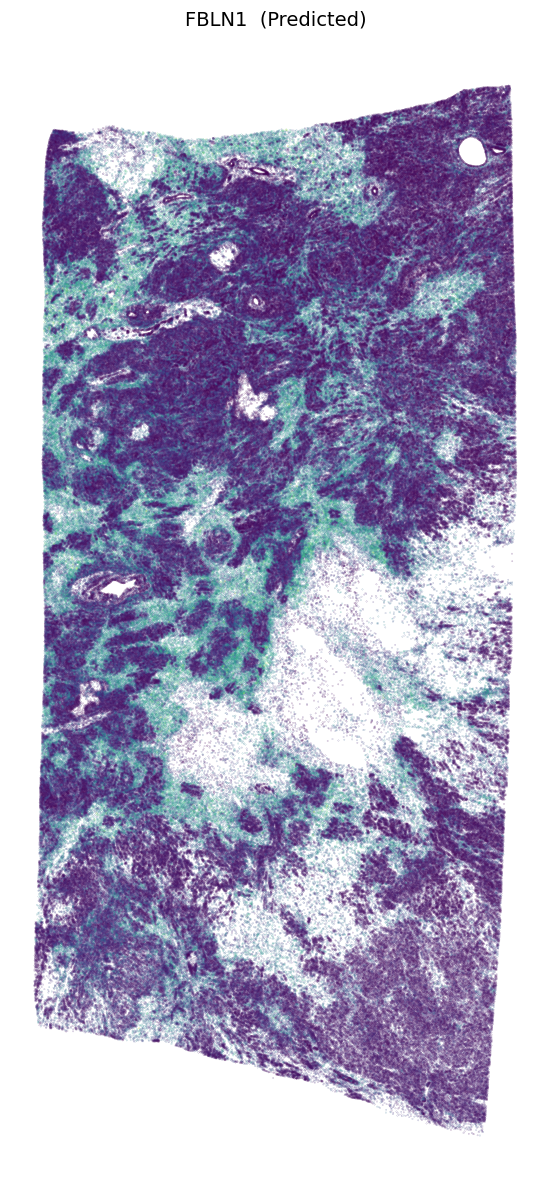

In [19]:
gene_name = 'FBLN1'
gene_idx = np.where(adata1.var_names == gene_name)[0]

plt.figure(figsize=(10, 15))
spatial = adata2.obsm['spatial']
value = panelA2[:, gene_idx].squeeze()
order = np.argsort(value)
plt.scatter(spatial[order, 0], spatial[order, 1], c=value[order], vmin=0, s=0.01)
plt.gca().set_aspect(1)
plt.axis('off')
plt.title(gene_name + '  (Predicted)', fontsize=14)
plt.show()